In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datathon/sample_submission.csv
/kaggle/input/datathon/test_x.csv
/kaggle/input/datathon/train.csv


# Veriyi Anlama ve Yükleme

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Verileri yükleme
train_data = pd.read_csv('/kaggle/input/datathon/train.csv')
test_data = pd.read_csv('/kaggle/input/datathon/test_x.csv') 

# İlk bir kaç satırı inceleme
print(train_data.head())
print(test_data.head())

/tmp/ipykernel_23/3376448775.py:11: DtypeWarning: Columns (13,15,19,30,32,37,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('/kaggle/input/datathon/train.csv')


   Basvuru Yili  Degerlendirme Puani Cinsiyet  Dogum Tarihi        Dogum Yeri  \
0          2014                 52.0    Erkek      4/6/1994  Altindag, Ankara   
1          2014                 30.0    Erkek     6/11/1993           Üsküdar   
2          2014                 18.0    Erkek     1/15/1986            Samsun   
3          2014                 40.0    Erkek      6/4/1991        Diyarbakır   
4          2014                 24.0    Erkek  2 Kasim 1992   Ankara/Altındağ   

  Ikametgah Sehri                    Universite Adi Universite Turu  \
0          Ankara           İHSAN DOĞRAMACI BİLKENT            Özel   
1        İstanbul           İHSAN DOĞRAMACI BİLKENT            Özel   
2        İstanbul  ULUSLARARASI KIBRIS ÜNİVERSİTESİ            Özel   
3        İstanbul       İSTANBUL ŞEHİR ÜNİVERSİTESİ            Özel   
4          Ankara          TURGUT ÖZAL ÜNİVERSİTESİ            Özel   

   Burslu ise Burs Yuzdesi Burs Aliyor mu?  ... Spor Dalindaki Rolunuz Nedir?  \
0    

# Eksik Veri Görselleştirme

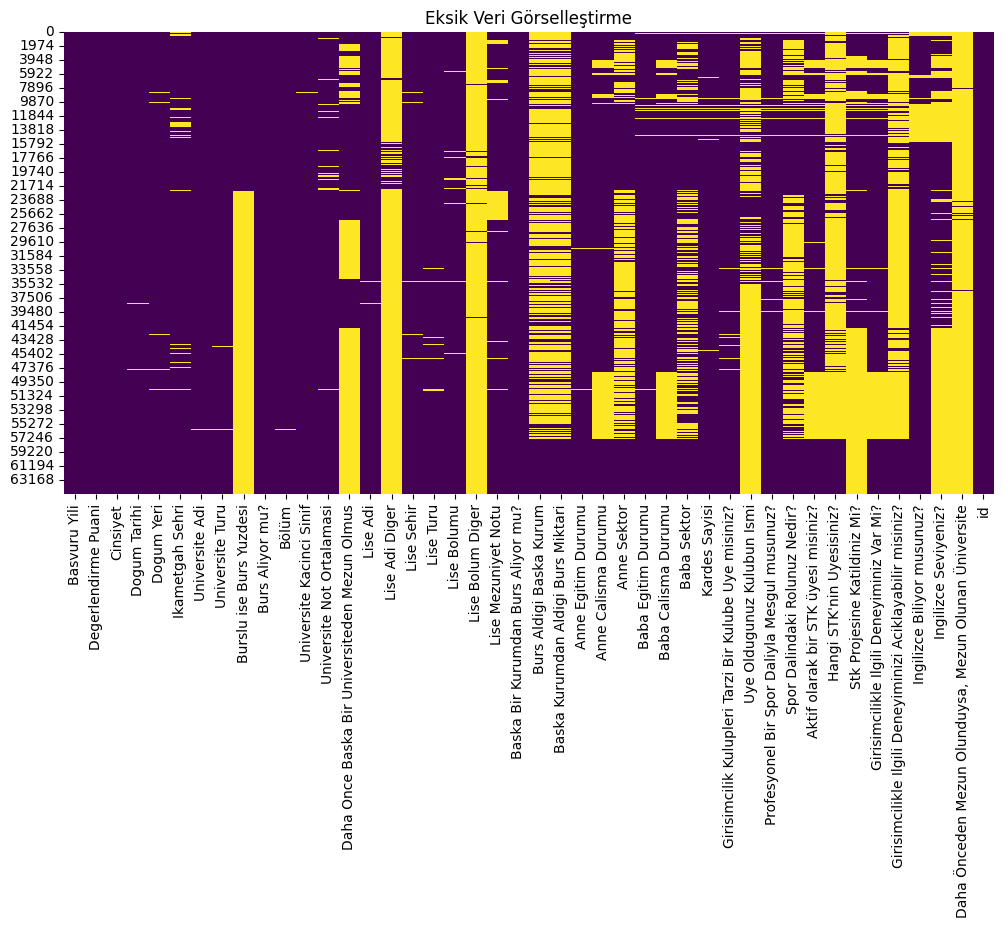

In [3]:
# Eksik verilerin ısı haritası çizilir
plt.figure(figsize=(12, 6))
sns.heatmap(train_data.isnull(), cbar=False, cmap="viridis")
plt.title('Eksik Veri Görselleştirme')
plt.show()

# Eksik Verileri Doldurma

In [4]:
# Eksik verileri doldurma
# Sayısal sütunları medyan ile dolduralım
for col in train_data.select_dtypes(include=['float64', 'int64']).columns:
    train_data[col].fillna(train_data[col].median(), inplace=True)

# Kategorik sütunları en sık görülen değerle dolduralım
for col in train_data.select_dtypes(include=['object']).columns:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)

# Tekrar eksik veri var mı kontrol edelim
print(train_data.isnull().sum())  # Eksik veri kalmaması gerekiyor


/tmp/ipykernel_23/3556226203.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(train_data[col].median(), inplace=True)
/tmp/ipykernel_23/3556226203.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

Basvuru Yili                                                 0
Degerlendirme Puani                                          0
Cinsiyet                                                     0
Dogum Tarihi                                                 0
Dogum Yeri                                                   0
Ikametgah Sehri                                              0
Universite Adi                                               0
Universite Turu                                              0
Burslu ise Burs Yuzdesi                                      0
Burs Aliyor mu?                                              0
Bölüm                                                        0
Universite Kacinci Sinif                                     0
Universite Not Ortalamasi                                    0
Daha Once Baska Bir Universiteden Mezun Olmus                0
Lise Adi                                                     0
Lise Adi Diger                                         

# Özellikleri (X) ve Hedefi (y) Belirleme

In [5]:
# Özellikler (X) ve hedef (y) ayarlama
X = train_data.drop('Degerlendirme Puani', axis=1)  # Tüm sütunlar hedef dışındakiler
y = train_data['Degerlendirme Puani']  # Hedef değişkenimiz "Değerlendirme Puani"


# Kategorik Verileri Sayısal Hale Getirme(Encoding) LabelEncoder

In [6]:
# Sütun türlerini kontrol edelim
print(X.dtypes)

# Karışık veri türlerine sahip sütunları düzeltelim (sayısal değerleri metne çeviriyoruz)
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype(str)  # Eğer karışık türde sütun varsa, string'e çeviriyoruz

# LabelEncoder ile kategorik sütunları sayısal hale getirme
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in X.select_dtypes(include=['object']).columns:
    X[col] = le.fit_transform(X[col])


Basvuru Yili                                                   int64
Cinsiyet                                                      object
Dogum Tarihi                                                  object
Dogum Yeri                                                    object
Ikametgah Sehri                                               object
Universite Adi                                                object
Universite Turu                                               object
Burslu ise Burs Yuzdesi                                      float64
Burs Aliyor mu?                                               object
Bölüm                                                         object
Universite Kacinci Sinif                                      object
Universite Not Ortalamasi                                     object
Daha Once Baska Bir Universiteden Mezun Olmus                 object
Lise Adi                                                      object
Lise Adi Diger                    

# Veriyi bölelim

In [7]:
# Veriyi %50 eğitim, %50 doğrulama olarak bölelim
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

# Belleği azaltmak için tip dönüşümü 

In [8]:
# Belleği azaltmak için tip dönüşümü yapalım
for col in X_train.select_dtypes(include=['float64']).columns:
    X_train[col] = X_train[col].astype('float32')

# Basit Model Eğitimi (Linear Regression)

In [9]:
# Modeli oluşturma
model = LinearRegression()

# Modeli eğitim verisiyle eğitme
model.fit(X_train, y_train)

# Doğrulama seti üzerinde tahmin yapma
y_pred = model.predict(X_val)

# RMSE'yi hesaplama
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Doğrulama RMSE: {rmse}")

Doğrulama RMSE: 9.44685583139031
